In [15]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from argparse import ArgumentParser
from keras.utils.vis_utils import plot_model
import h5py
import awkward as ak

from general import table_to_numpy, TitledModel, plot_loss_history, custom_objects, HDF5File, MaxPassLayer, feat, load_normalization

from general import feat, accuracy_max, TitledModel, plot_loss_history

In [21]:
def load_data_b(path, *args):
    with HDF5File(path, "r") as f:
        data = f["data"]
        offset = f["offset"]
        scale = f["scale"]
    flav = data["jet_flav"] * scale["jet_flav"] + offset["jet_flav"]
    data["jet_flav"] = ak.values_astype(flav + 0.5 * np.sign(flav), int)
    data = data[(ak.sum(data["jet_flav"] == 5, axis=1) == 1) & (ak.sum(data["jet_flav"] == -5, axis=1) == 1)]
    data["weight"] = data["weight"] * scale["weight"] + offset["weight"]

    flav = np.asarray(ak.fill_none(ak.pad_none(data["jet_flav"], ak.max(ak.num(data["jet_flav"]))), 0))
    label = ((flav == 5)[:, :, None] & (flav == -5)[:, None, :]).astype(float).reshape((-1, flav.shape[1] ** 2))
    weight = abs(np.asarray(data["weight"]))
    data = [table_to_numpy(data, arg) for arg in args]
    return data, label, [weight]*len(label) if isinstance(label, list) else weight

def make_model_b(input_shapes, input_titles, num_layers_per_input, num_layers, num_nodes, activation, dropout,
               num_outputs, output_titles, lr, decay):
    if not isinstance(activation, (list, tuple)):
        activation = [activation]
    if not isinstance(num_nodes, (list, tuple)):
        num_nodes = [num_nodes]

    inputs = []
    for input_shape in input_shapes:
        inputs.append(keras.Input(shape=input_shape[1:]))
    xs = []
    for i, num_layer_input in enumerate(num_layers_per_input):
        x = inputs[i]
        for j in range(num_layer_input):
            act = activation[j % len(activation)]
            nn = num_nodes[j % len(num_nodes)]
            x = keras.layers.Dense(nn, activation=act)(x)
            if dropout:
                x = keras.layers.Dropout(dropout)(x)
        if len(inputs[i].shape) == 3:
            x = keras.layers.Flatten()(x)
        xs.append(x)
    x = keras.layers.Concatenate()(xs)

    for i in range(num_layers):
        act = activation[i % len(activation)]
        nn = num_nodes[i % len(num_nodes)]
        x = keras.layers.Dense(nn, activation=act)(x)
        if dropout:
            x = keras.layers.Dropout(dropout)(x)
    if num_outputs == 1:
        cls_activation = "sigmoid"
        loss = "binary_crossentropy"
    else:
        cls_activation = "softmax"
        loss = "categorical_crossentropy"
    cls = keras.layers.Dense(num_outputs, activation=cls_activation, name="cls")(x)
    model = TitledModel(inputs=inputs, outputs=[cls], input_titles=input_titles, output_titles=output_titles)
    model.compile(
        loss=loss,
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=decay),
        metrics=[],
        weighted_metrics=[accuracy_max]
    )

    return model

def load_data(path, inputs, targets):
    with HDF5File(path, "r") as f:
        data = f["data"]
        offset = f["offset"]
        scale = f["scale"]
    data["weight"] = data["weight"] * scale["weight"] + offset["weight"]

    weight = abs(np.asarray(data["weight"]))
    data_x = [table_to_numpy(data, input) for input in inputs]
    if isinstance(targets[0], list):
        data_y = []
        for target in targets:
            data_y.append(table_to_numpy(data, target))
    else:
        data_y = table_to_numpy(data, targets)
    return data_x, data_y, weight


def make_model(input_shapes, input_titles, prev_models, num_layers_per_input, num_layers, num_nodes, activation, dropout,
               output_titles, lr, decay):
    if not isinstance(activation, (list, tuple)):
        activation = [activation]
    if not isinstance(num_nodes, (list, tuple)):
        num_nodes = [num_nodes]

    inputs = []
    for input_shape in input_shapes:
        inputs.append(keras.Input(shape=input_shape[1:]))
    xs = []
    input_offset = 0
    for prev_model in prev_models:
        xs.append(prev_model(inputs[input_offset:input_offset + len(prev_model.input_titles)]))
        input_offset += len(prev_model.input_titles)
    xs += inputs[input_offset:]
    xs_next = []
    for i, num_layer_input in enumerate(num_layers_per_input):
        x = xs[i]
        for j in range(num_layer_input):
            act = activation[j % len(activation)]
            nn = num_nodes[j % len(num_nodes)]
            x = keras.layers.Dense(nn, activation=act)(x)
            if dropout:
                x = keras.layers.Dropout(dropout)(x)
        if len(xs[i].shape) == 3:
            x = keras.layers.Flatten()(x)
        xs_next.append(x)
    del xs
    x = keras.layers.Concatenate()(xs_next)

    for i in range(num_layers):
        act = activation[i % len(activation)]
        nn = num_nodes[i % len(num_nodes)]
        x = keras.layers.Dense(nn, activation=act, name=f"reg_tt{i}")(x)
        if dropout:
            x = keras.layers.Dropout(dropout)(x)
    reg_activation = "linear"
    loss = "mean_squared_error"
    if isinstance(output_titles[0], list):
        reg = []
        for output_title in output_titles:
            pname = output_title[0].split("_")[0]
            reg.append(keras.layers.Dense(len(output_title), activation=reg_activation, name=pname)(x))
    else:
        reg = keras.layers.Dense(len(output_titles), activation=reg_activation, name="reg_tt")(x)
    model = TitledModel(input_titles, output_titles, inputs=inputs, outputs=reg)
    model.compile(
        loss=loss,
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=decay),
        metrics=[],
        weighted_metrics=[])

    return model

In [6]:
path       = '/nfs/dust/cms/user/stafford/For_Emanuele/reconn/skims/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/'
train_file = path + 'traindata.hdf5'
valid_file = path + 'validatedata.hdf5'
modelb     = 'model_bcls.hdf5'

In [12]:
# Provided model construction details
features1 = feat("jet") + ["jet_btag"]
features2 = feat("alep") + feat("lep") + ["met_pt", "met_phi", "met_x", "met_y"]
train    = load_data_b(train_file, features1, features2)
validate = load_data_b(valid_file, features1, features2)


In [16]:
# Recreate the model architecture exactly as it was before
model_b = make_model_b(
    [t.shape for t in train[0]],  # Input shapes
    [features1, features2],       # Input titles
    [2, 0],                       # Number of layers per input
    2,                            # Number of layers after concatenation
    200,                          # Number of nodes per layer
    "relu",                       # Activation function
    0.25,                         # Dropout rate
    train[1].shape[1],            # Number of outputs
    [],                           # Output titles
    0.0003,                       # Learning rate
    0                             # Learning rate decay
)

In [17]:
# Load the weights into the recreated model
model_b.load_weights(modelb)

In [26]:
b_out = MaxPassLayer(2)([model_b.output, model_b.inputs[0]])
model_bbar = TitledModel(
    model_b.input_titles,
    [p + t.split("_")[1] for t in model_b.input_titles[0] for p in ("bot_", "abot_")],
    inputs=model_b.inputs, outputs=[b_out])
model_bbar.trainable = False

inputs = model_b.input_titles + [["met_pt", "met_phi", "met_x", "met_y"] + feat("lep") + feat("alep")]
targets = [
    ["top_x", "top_y", "top_z", "top_mass"],
    ["atop_x", "atop_y", "atop_z", "atop_mass"],
]

train = load_data(train_file, inputs, targets)
validate = load_data(valid_file, inputs, targets)

model_tt = make_model(
    [t.shape for t in train[0]],  # List of input shapes derived from the training data (features)
    inputs,                       # List of input feature names
    [model_bbar],                 # List of previous models to include (in this case, `model_bbar`)
    [0, 2],                       # Number of layers per input for each input feature group
    3,                            # Total number of additional layers after combining inputs
    800,                          # Number of nodes per dense layer
    "relu",                       # Activation function to use in the dense layers
    0.25,                         # Dropout rate to apply after each dense layer
    targets,                      # List of target feature names for the output
    0.001,                        # Learning rate for the optimizer
    0                             # Learning rate decay
)

norm = load_normalization(train_file)
keras.models.save_model(model_tt, "model_tt.hdf5")
earlystop = keras.callbacks.EarlyStopping(patience=6)
checkpoint = keras.callbacks.ModelCheckpoint(
    "model_tt.hdf5", save_best_only=True, verbose=1)

epochs = 3
batch_size = 2**13

In [24]:
model_tt.summary()

Model: "titled_model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 800)          16800       ['input_15[0][0]']               
                                                                                                  
 dropout_18 (Dropout)           (None, 800)          0           ['dense_12[0][0]']               
                                                                                                  
 input_13 (InputLayer)          [(None, 7, 9)]       0           []                               
                                                                                     

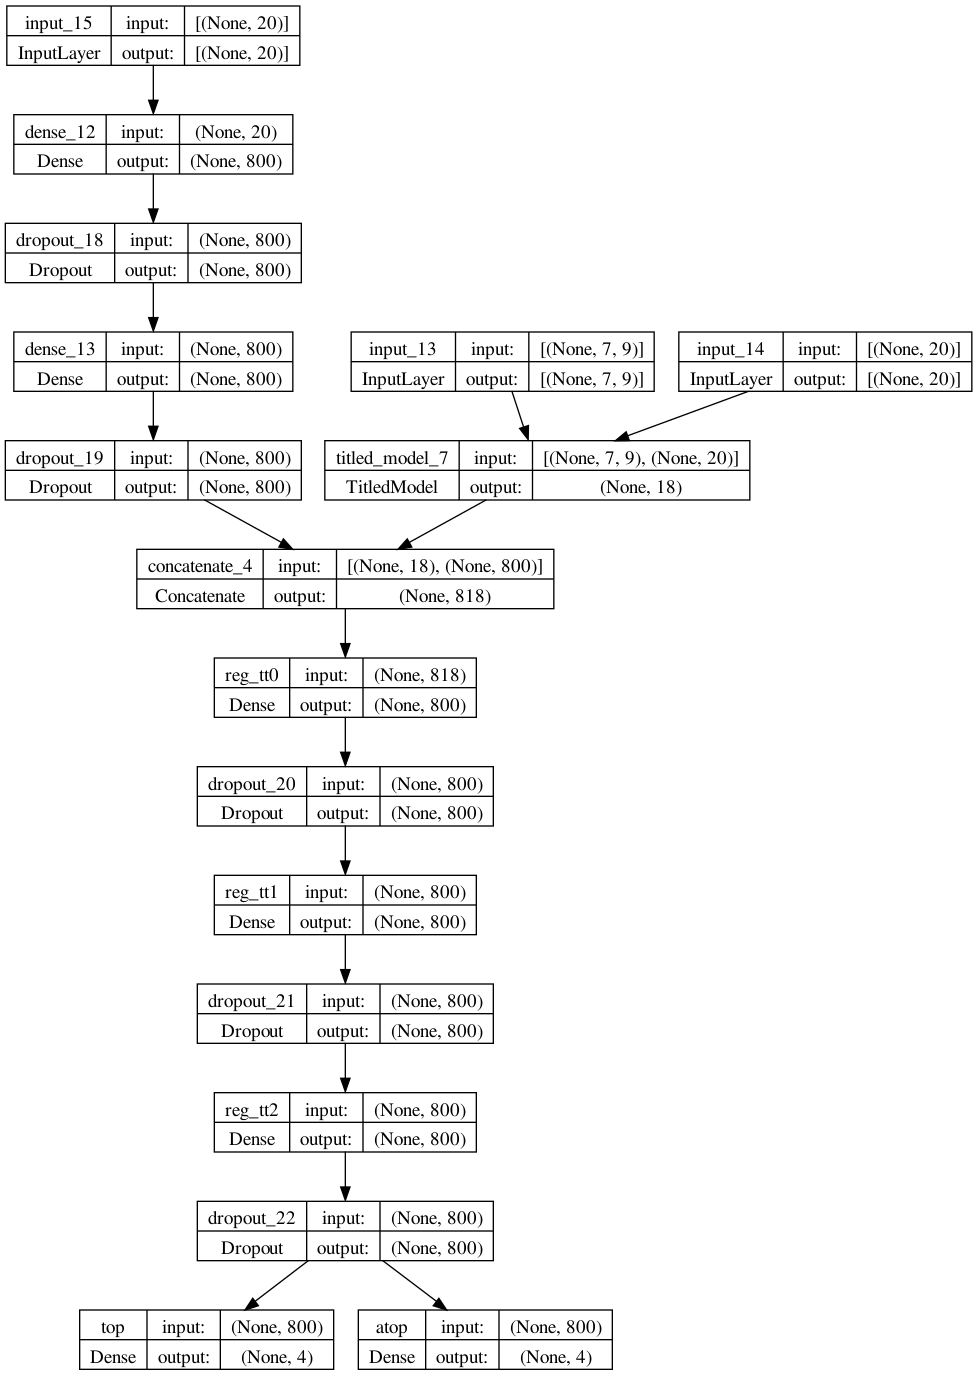

In [25]:
plot_model(model_tt, show_shapes=True, show_layer_names=True)

## original version

In [27]:
history = model_tt.fit(
    train[0], train[1], sample_weight=train[2], batch_size=batch_size,
    epochs=epochs, validation_data=validate,
    callbacks=[earlystop, checkpoint])
plot_loss_history(history, "loss_tt.svg")

Epoch 1/3
86/86 [==============================] - ETA: 0s - loss: 0.0742 - top_loss: 0.0371 - atop_loss: 0.0371
Epoch 1: val_loss improved from inf to 0.06203, saving model to model_tt.hdf5
86/86 [==============================] - 115s 1s/step - loss: 0.0742 - top_loss: 0.0371 - atop_loss: 0.0371 - val_loss: 0.0620 - val_top_loss: 0.0310 - val_atop_loss: 0.0311
Epoch 2/3
86/86 [==============================] - ETA: 0s - loss: 0.0652 - top_loss: 0.0326 - atop_loss: 0.0326
Epoch 2: val_loss improved from 0.06203 to 0.06100, saving model to model_tt.hdf5
86/86 [==============================] - 50s 587ms/step - loss: 0.0652 - top_loss: 0.0326 - atop_loss: 0.0326 - val_loss: 0.0610 - val_top_loss: 0.0304 - val_atop_loss: 0.0306
Epoch 3/3
86/86 [==============================] - ETA: 0s - loss: 0.0640 - top_loss: 0.0319 - atop_loss: 0.0321
Epoch 3: val_loss improved from 0.06100 to 0.06048, saving model to model_tt.hdf5
86/86 [==============================] - 54s 633ms/step - loss: 0.064